In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
! pip install evaluate
import evaluate
import torch
from sklearn.model_selection import train_test_split


2025-09-10 14:06:56.031752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757513216.221215      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757513216.276370      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvid

In [3]:
# Model name on Hugging Face Hub
model_name = "bert-base-multilingual-cased"

# Download tokenizer + weights
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=5)

print("✅ mBERT downloaded and ready!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ mBERT downloaded and ready!


In [4]:
path = "/kaggle/input/complaints/Dataset complaint Management System (1).csv"

df = pd.read_csv(
    path,
    encoding="cp1256",
    sep=",",                  # change if your delimiter is not comma
    engine="python",
    quoting=csv.QUOTE_NONE,   # don't treat quotes specially
    escapechar="\\",          # allow \" inside fields
    on_bad_lines="skip"
)

In [5]:
import pandas as pd

path = r"/kaggle/input/complaints/Dataset complaint Management System (1).csv"

def load_any_table(path):
    # Peek first few bytes to detect XLSX/ZIP
    with open(path, "rb") as f:
        sig = f.read(4)
    is_zip = sig == b"PK\x03\x04"  # XLSX is a zip

    if is_zip:
        # It's actually an Excel file with a wrong extension
        return pd.read_excel(path, engine="openpyxl")
    else:
        # It's a real CSV
        for enc in ["utf-8-sig", "cp1256", "ISO-8859-1"]:
            try:
                return pd.read_csv(
                    path,
                    encoding=enc,
                    sep=",",
                    engine="python",
                    quotechar='"',
                    doublequote=True,
                    escapechar="\\",
                    on_bad_lines="skip",
                    skipinitialspace=True,
                )
            except Exception:
                continue
        raise RuntimeError("Could not parse as CSV with common encodings.")

df = load_any_table(path)
TEXT_COL = "ComplaintText"   # <-- change to exact name
LABEL_COL = "Category"        # <-- change to exact name

# Keep only those two
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Rename to standard names
df = df.rename(columns={TEXT_COL: "text", LABEL_COL: "labels"})

print(df.shape)
print(df.head(5))

(4061, 2)
                                                text                  labels
0  Access to certain buildings is restricted with...    Facilities_Logistics
1         Access to supplementary videos is blocked.       Coursers_Training
2  Administrative emails are not replied to promp...  Certificates_Documents
3  Administrative office does not respond to urge...  Certificates_Documents
4  Administrative office hours are not updated on...  Certificates_Documents


In [6]:


def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
tokenized_datasets = df['text'].apply(lambda x: tokenize_function({'text': x}))

# Adding tokenized columns to the DataFrame
df['input_ids'] = tokenized_datasets.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_datasets.apply(lambda x: x['attention_mask'])

In [7]:
from sklearn.preprocessing import LabelEncoder

# Label encoding the labels
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])

# Show the label encoding
print(label_encoder.classes_)


['Certificates_Documents' 'Coursers_Training' 'Facilities_Logistics'
 'Finance_Admin' 'IT_Support ']


In [12]:
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} → {idx}")

Certificates_Documents → 0
Coursers_Training → 1
Facilities_Logistics → 2
Finance_Admin → 3
IT_Support  → 4


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [9]:
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset
# Split the data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% temp (for validation and test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Move tensors to GPU if device is CUDA
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset
import torch

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Function to tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Create Dataset from pandas dataframe
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply tokenization to the datasets (returns dictionaries)
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Move tensors to the device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Function to move data to the correct device after tokenization
def move_to_device(dataset):
    def move_example(example):
        # Only move tensors (input_ids, attention_mask, labels) to device
        return {k: torch.tensor(v).to(device) if isinstance(v, (list, torch.Tensor)) else v for k, v in example.items()}
    return dataset.map(move_example, batched=False)

# Move datasets to device (GPU or CPU)
train_dataset = move_to_device(train_dataset)
val_dataset = move_to_device(val_dataset)
test_dataset = move_to_device(test_dataset)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Ensure the model is on the correct device (GPU or CPU)
model = model.to(device)


Map:   0%|          | 0/3248 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Map:   0%|          | 0/3248 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Training dataset size: 3248
Validation dataset size: 406
Test dataset size: 407


In [11]:
print('Train_Dataset:',train_df['labels'].value_counts())

Train_Dataset: labels
4    799
1    681
3    607
0    596
2    565
Name: count, dtype: int64


In [14]:
from transformers import DataCollatorWithPadding

# Create a data collator to batch data correctly
ddata_collator = DataCollatorWithPadding(tokenizer)


In [16]:
for param in model.bert.encoder.parameters():
    param.requires_grad = False


In [17]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔢 Total parameters: {total_params:,}")
print(f"🟢 Trainable parameters: {trainable_params:,}")
print(f"🟡 Frozen parameters: {total_params - trainable_params:,}")

🔢 Total parameters: 177,857,285
🟢 Trainable parameters: 92,802,821
🟡 Frozen parameters: 85,054,464


In [18]:
!pip uninstall -y wandb

from transformers import Trainer, TrainingArguments

# Define the training arguments
# Load the accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)  # Convert logits to class predictions
    return accuracy_metric.compute(predictions=preds, references=labels)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',             # Directory to save results and checkpoints
    num_train_epochs=30,                 # Number of training epochs
    per_device_train_batch_size=16,     # Batch size for training
    per_device_eval_batch_size=16,      # Batch size for evaluation
    warmup_steps=500,                   # Number of warmup steps for learning rate scheduler
    weight_decay=0.1,                  # Strength of weight decay
    logging_dir='./logs',               # Directory for storing logs
    logging_steps=10,
               # Save model after each epoch
       # Load the best model at the end of training
    metric_for_best_model="accuracy",  # Use accuracy for evaluating the best model
    report_to=None                      # Disable WandB logging
)

# Initialize the Trainer with the model and datasets
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,            # Validation dataset
    compute_metrics=compute_metrics,     # Use the custom compute_metrics function
    tokenizer=tokenizer,                 # Pass the tokenizer
    data_collator=ddata_collator         # Use the data collator for padding and tokenization
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model("./final_model")

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate(val_dataset)
print(f"Validation results: {eval_results}")

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")
train_results = trainer.evaluate(train_dataset)
print(f"train results: {train_results}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: wandb 0.20.1
Uninstalling wandb-0.20.1:
  Successfully uninstalled wandb-0.20.1


/tmp/ipykernel_36/793572350.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.624200
20,1.626600
30,1.610900
40,1.618300
50,1.635300
60,1.605000
70,1.612000
80,1.616200
90,1.628600
100,1.595600


Validation results: {'eval_loss': 0.679395854473114, 'eval_accuracy': 0.8866995073891626, 'eval_runtime': 6.5653, 'eval_samples_per_second': 61.841, 'eval_steps_per_second': 3.96, 'epoch': 30.0}
Test results: {'eval_loss': 0.6546241044998169, 'eval_accuracy': 0.8992628992628993, 'eval_runtime': 6.5709, 'eval_samples_per_second': 61.94, 'eval_steps_per_second': 3.957, 'epoch': 30.0}
train results: {'eval_loss': 0.00021030755306128412, 'eval_accuracy': 1.0, 'eval_runtime': 52.1721, 'eval_samples_per_second': 62.255, 'eval_steps_per_second': 3.891, 'epoch': 30.0}


In [20]:
class_names = list(label_encoder.classes_)
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix_per_class(y_true, y_pred, class_names=None, split_name=""):
    classes = np.unique(y_true)
    for c in classes:
        # Binary view: this class vs all others
        y_true_bin = (y_true == c).astype(int)
        y_pred_bin = (y_pred == c).astype(int)

        cm = confusion_matrix(y_true_bin, y_pred_bin)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=[f"Not {class_names[c]}", class_names[c]] 
            if class_names is not None else ["Other", str(c)]
        )
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix — {split_name} — Class {class_names[c] if class_names else c}")
        plt.show()




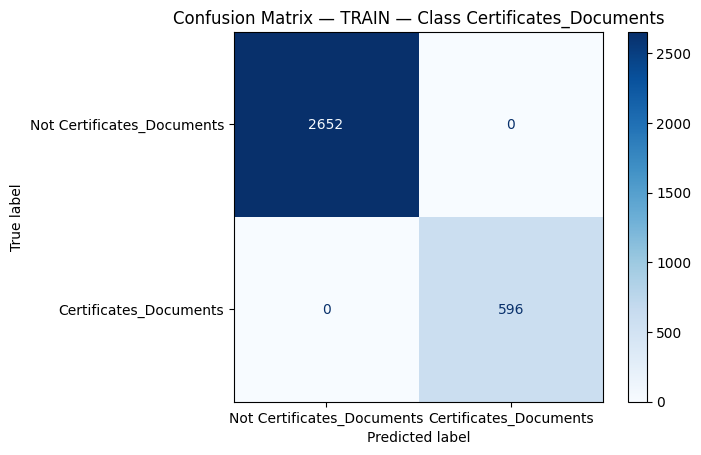

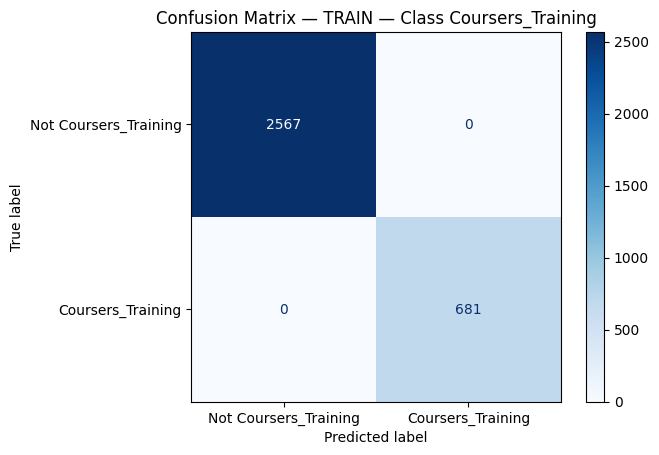

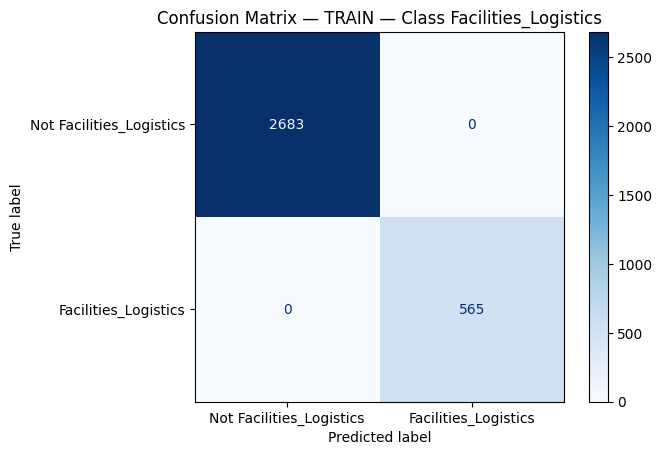

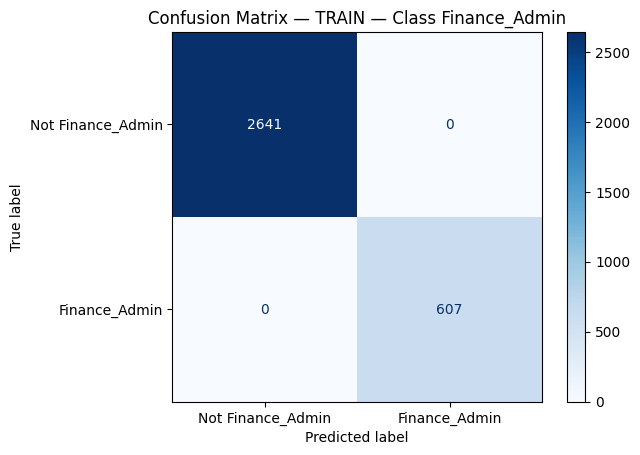

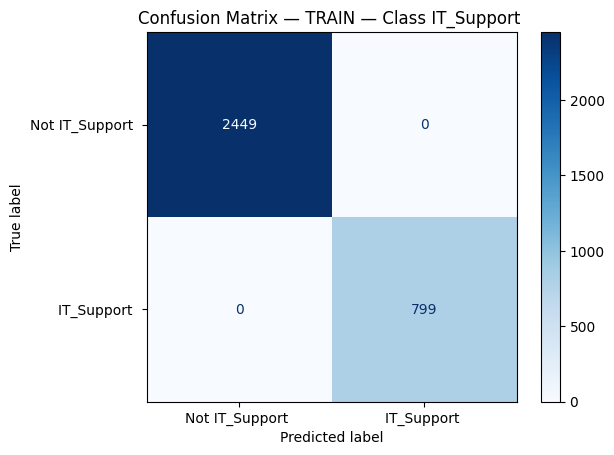

In [21]:
# --- TRAIN ---
pred_train = trainer.predict(train_dataset)
y_true_train = pred_train.label_ids
y_pred_train = pred_train.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_train, y_pred_train, class_names, split_name="TRAIN")


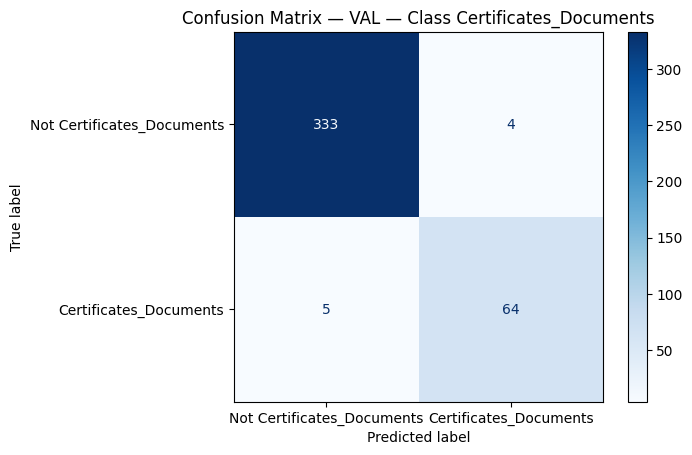

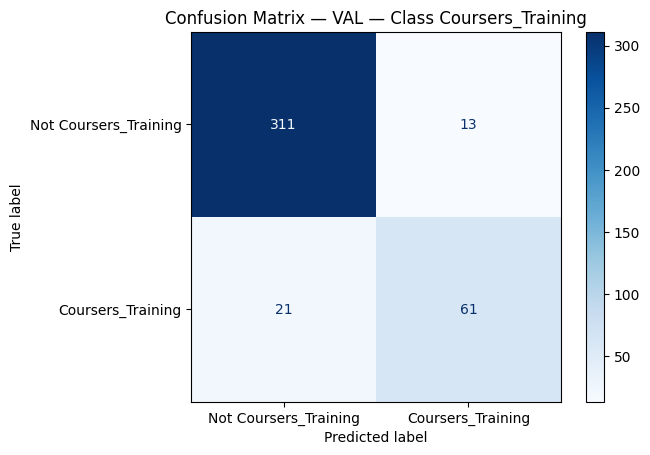

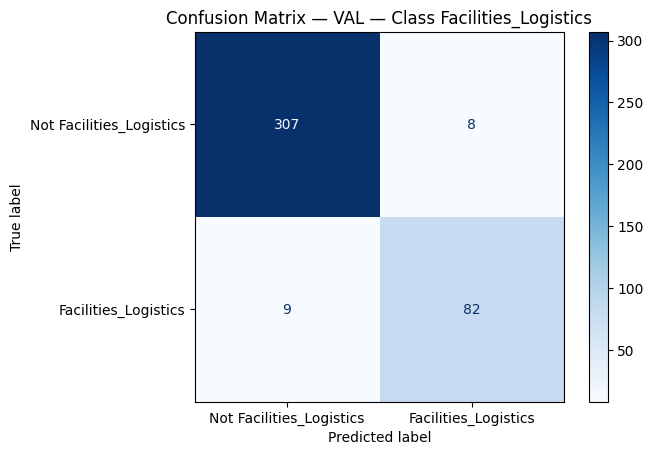

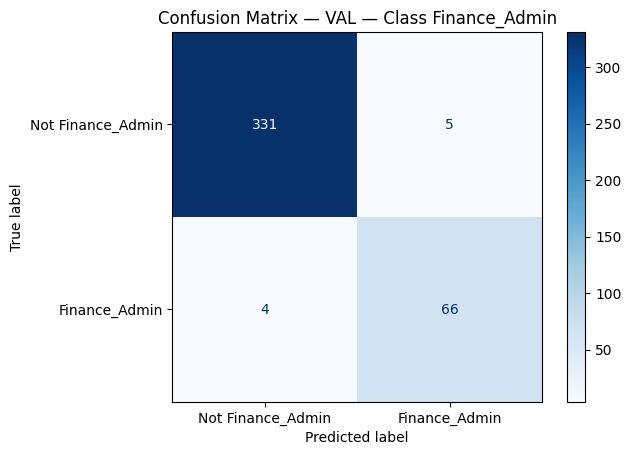

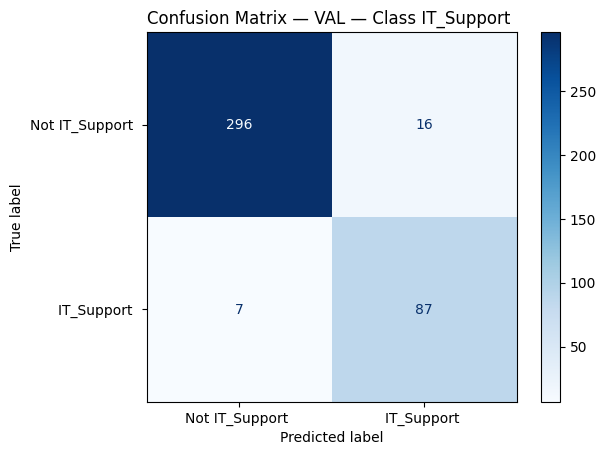

In [22]:
# --- VAL ---
pred_val = trainer.predict(val_dataset)
y_true_val = pred_val.label_ids
y_pred_val = pred_val.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_val, y_pred_val, class_names, split_name="VAL")


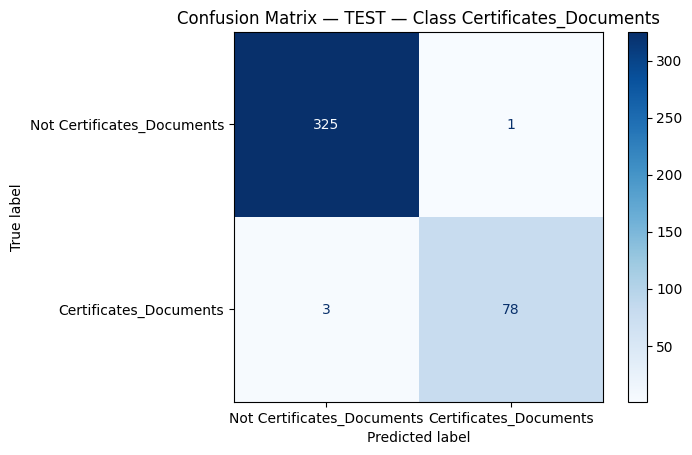

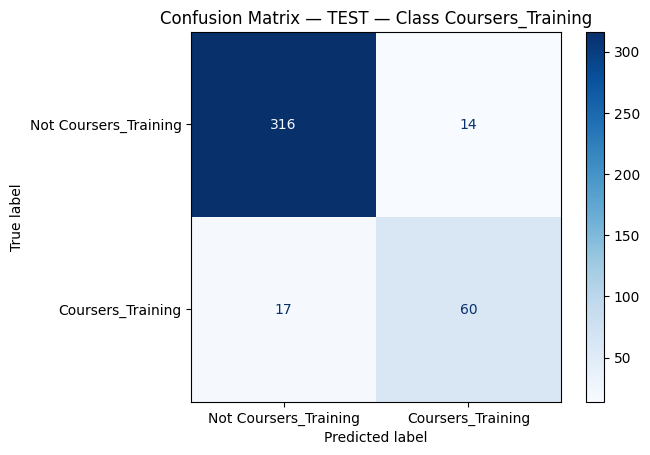

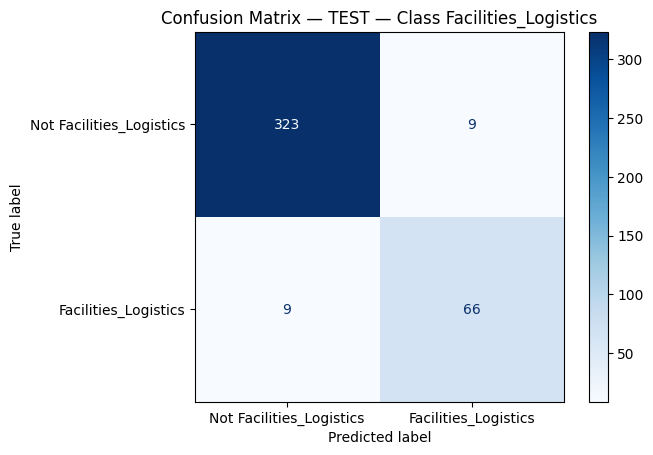

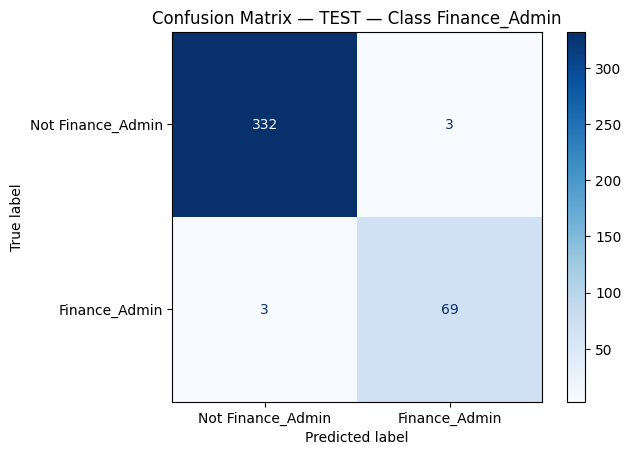

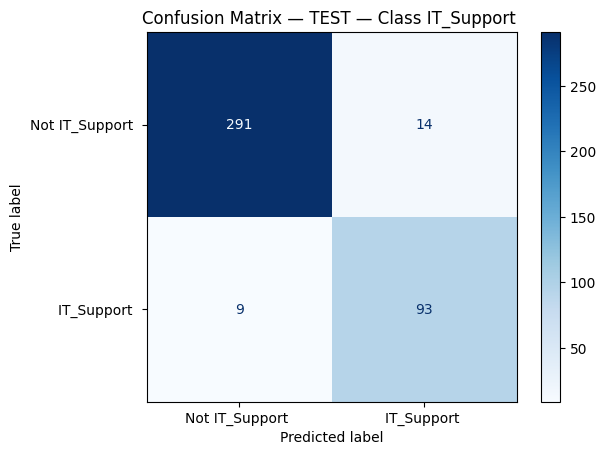

In [23]:
# --- TEST ---
pred_test = trainer.predict(test_dataset)
y_true_test = pred_test.label_ids
y_pred_test = pred_test.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_test, y_pred_test, class_names, split_name="TEST")
